In [1]:
import time
import numpy as np

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

In [2]:
from tensorflow.python.client import device_lib

def check_tensor_core_gpu_present():
    local_device_protos = device_lib.list_local_devices()
    for line in local_device_protos:
        if "compute capability" in str(line):
            compute_capability = float(line.physical_device_desc.split("compute capability: ")[-1])
            if compute_capability>=7.0:
                return True

print("TensorFlow version is", tf.__version__)

try:
    # check and assert TensorFlow >= 1.14
    tf_version_list = tf.__version__.split(".")
    if int(tf_version_list[0]) < 2:
        assert int(tf_version_list[1]) >= 14
except:
    print("TensorFlow 1.14.0 or newer is required.")
    
print("Tensor Core GPU Present:", check_tensor_core_gpu_present())
if check_tensor_core_gpu_present():
    pass
else:
    !nvidia-smi
    assert check_tensor_core_gpu_present() == True

TensorFlow version is 1.15.0
Tensor Core GPU Present: True


In [3]:
# The data, split between train and test sets

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

num_classes = np.max(y_train) + 1

# Convert class vectors to binary class matrices

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [4]:
def normalize(ndarray):
    ndarray = ndarray.astype("float32")
    ndarray = ndarray/255.0
    return ndarray

x_train = normalize(x_train)
x_test = normalize(x_test)

In [5]:
def create_model(num_classes=10):
    """
    Returns a simple CNN suitable for classifiying images from CIFAR10
    """
    # model parameters
    act = "relu"
    pad = "same"
    ini = "he_uniform"
    
    model = tf.keras.models.Sequential([
        Conv2D(128, (3, 3), activation=act, padding=pad, kernel_initializer=ini,
               input_shape=(32,32,3)),
        Conv2D(256, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
        Conv2D(256, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
        Conv2D(256, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(256, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
        Conv2D(256, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
        Conv2D(512, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
        Conv2D(512, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(256, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
        Conv2D(256, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
        Conv2D(256, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
        Conv2D(128, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
        MaxPooling2D(pool_size=(4,4)),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        Dense(num_classes, activation="softmax")
    ])

    return model

In [6]:
model = create_model(num_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 256)       5

In [14]:
# training parameters
BATCH_SIZE = 320
N_EPOCHS = 1
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.5)

In [21]:
def train_model(mixed_precision, optimizer):
    """
    Trains a CNN to classify images on CIFAR10,
    and returns the training and classification performance
    
    Args:
        mixed_precision: `True` or `False`
        optimizer: An instance of `tf.keras.optimizers.Optimizer`
    """
    model = create_model(num_classes)

    if mixed_precision:
        import tensorflow
        optimizer = tensorflow.compat.v1.train.experimental.enable_mixed_precision_graph_rewrite(optimizer)

    model.compile(loss="categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])
    
    train_start = time.time()
    

    train_log = model.fit(x_train, y_train,
                          batch_size=BATCH_SIZE,
                          epochs=N_EPOCHS,
                          use_multiprocessing=True,
                          workers=2)
    

    train_end = time.time()
    score=model.evaluate(x_test,y_test,verbose=0)
    
    #results = #{"test_loss": score[0],
               #"test_acc": score[1],
               #"train_time": train_end-train_start,
               #"train_log": train_log}
    results = {"test_loss": score[0],
               "test_acc": score[1],
               "train_time": train_end-train_start,
               "train_log": train_log}
    
    return results

In [23]:
fp32_results = train_model(mixed_precision=False, optimizer=opt)

test_acc = round(fp32_results["test_acc"]*100, 1)
train_time = round(fp32_results["train_time"], 1)

print(test_acc, "% achieved in", train_time, "seconds")

Train on 50000 samples
50000/50000 [==============================] - 21s 422us/sample - loss: 1.7375 - accuracy: 0.3658
27.5 % achieved in 26.6 seconds


In [10]:
# to ensure accuracy of timing benchmark
# we give the GPU 10 seconds to cool down

tf.keras.backend.clear_session()

time.sleep(10)

In [11]:
mp_results = train_model(mixed_precision=True, optimizer=opt)

#test_acc = round(mp_results["test_acc"]*100, 1)
train_time = round(mp_results["train_time"], 1)

print('test_acc, "% achieved in"', train_time, "seconds")

im here
started
st_time:  1600611685.4141238
Train on 50000 samples
Epoch 1/10
50000/50000 [==============================] - 25s 505us/sample - loss: 1.7807 - accuracy: 0.3497
Epoch 2/10
50000/50000 [==============================] - 22s 439us/sample - loss: 1.2834 - accuracy: 0.5393
Epoch 3/10
50000/50000 [==============================] - 22s 434us/sample - loss: 1.0291 - accuracy: 0.6336
Epoch 4/10
50000/50000 [==============================] - 22s 441us/sample - loss: 0.8596 - accuracy: 0.6950
Epoch 5/10
50000/50000 [==============================] - 22s 440us/sample - loss: 0.7354 - accuracy: 0.7424
Epoch 6/10
50000/50000 [==============================] - 22s 449us/sample - loss: 0.6386 - accuracy: 0.7766
Epoch 7/10
50000/50000 [==============================] - 22s 438us/sample - loss: 0.5585 - accuracy: 0.8059
Epoch 8/10
50000/50000 [==============================] - 22s 442us/sample - loss: 0.4795 - accuracy: 0.8340
Epoch 9/10
50000/50000 [==============================] - 22

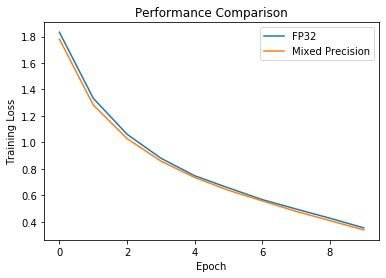

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(fp32_results["train_log"].history["loss"], label="FP32")
plt.plot(mp_results["train_log"].history["loss"], label="Mixed Precision")
plt.title("Performance Comparison")
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [13]:
speed_up = int(100 * fp32_results["train_time"]/mp_results["train_time"]) - 100

print("Performance Improvement:", speed_up, "%")

Performance Improvement: 75 %
